In [72]:
import tensorflow as tf
from tensorflow.keras import layers, Model
import glob, os
import matplotlib.pyplot as plt
import numpy as np
import glob
from sklearn.model_selection import train_test_split

# Paths
image_dir = "/content/drive/MyDrive/Colab Notebooks/data_dataset_voc/JPEGImages"
mask_dir  = "/content/drive/MyDrive/Colab Notebooks/data_dataset_voc/SegmentationClassEncoded"

all_images = [f for f in glob.glob(os.path.join(image_dir, "*.jpg")) if os.path.isfile(f)]
all_masks  = [f for f in glob.glob(os.path.join(mask_dir, "*.png")) if os.path.isfile(f)]
all_images.sort()
all_masks.sort()

X_train, X_val, Y_train, Y_val = train_test_split(all_images, all_masks, test_size=0.2, random_state=42)

print(f"Number of training images: {len(X_train)}")
print(f"Number of validation images: {len(X_val)}")


Number of training images: 240
Number of validation images: 61


In [88]:
IMG_HEIGHT = 128
IMG_WIDTH  = 128
BATCH_SIZE = 8
NUM_CLASSES = 3
EPOCHS = 20

In [89]:
import numpy as np
import cv2
import tensorflow as tf

def data_gen(image_paths, mask_paths, batch_size):
    while True:
        idxs = np.arange(len(image_paths))
        np.random.shuffle(idxs)

        for i in range(0, len(image_paths), batch_size):
            batch_idx = idxs[i:i+batch_size]
            batch_images = []
            batch_masks  = []

            for j in batch_idx:
                img = cv2.imread(image_paths[j])
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
                img = img / 255.0
                batch_images.append(img)
                mask = cv2.imread(mask_paths[j], cv2.IMREAD_GRAYSCALE)
                mask = cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_NEAREST)
                batch_masks.append(mask[..., np.newaxis])

            yield np.array(batch_images, dtype=np.float32), np.array(batch_masks, dtype=np.uint8)


In [90]:
def unet_mobilenet(input_size=(IMG_HEIGHT, IMG_WIDTH, 3), num_classes=NUM_CLASSES):
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_size,
                                                   include_top=False,
                                                   weights='imagenet')

    # Skip connections
    layer_names = [
        'block_1_expand_relu',   # 64x64
        'block_3_expand_relu',   # 32x32
        'block_6_expand_relu',   # 16x16
        'block_13_expand_relu',  # 8x8
    ]
    skips = [base_model.get_layer(name).output for name in layer_names]

    encoder = tf.keras.Model(inputs=base_model.input, outputs=skips)
    encoder.trainable = False

    inputs = tf.keras.Input(shape=input_size)
    x = encoder(inputs)[-1]  # bottleneck

    # Decoder
    for skip in reversed(encoder(inputs)[:-1]):
        x = layers.Conv2DTranspose(skip.shape[-1], 3, strides=2, padding='same')(x)
        x = layers.concatenate([x, skip])
        x = layers.Conv2D(skip.shape[-1], 3, activation='relu', padding='same')(x)
        x = layers.Conv2D(skip.shape[-1], 3, activation='relu', padding='same')(x)

    # Extra upsampling to match input size
    x = layers.Conv2DTranspose(32, 3, strides=2, padding='same')(x)
    x = layers.Conv2D(32, 3, activation='relu', padding='same')(x)
    x = layers.Conv2D(32, 3, activation='relu', padding='same')(x)

    outputs = layers.Conv2D(num_classes, 1, activation=None)(x)
    return tf.keras.Model(inputs=inputs, outputs=outputs)



Model: "functional_23"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_28      │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_22       │ [(None, 64, 64,   │    616,256 │ input_layer_28[0… │
│ (Functional)        │ 96), (None, 32,   │            │ input_layer_28[0… │
│                     │ 32, 144), (None,  │            │                   │
│                     │ 16, 16, 192),     │            │                   │
│                     │ (None, 8, 8,      │            │                   │
│                     │ 576)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_48 │ (None, 16, 16,    │    995,520 │ functional_22[0]… │
│ (Conv2DTranspose)   │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_37      │ (None, 16, 16,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 384)              │            │ functional_22[1]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_105 (Conv2D) │ (None, 16, 16,    │    663,744 │ concatenate_37[0… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_106 (Conv2D) │ (None, 16, 16,    │    331,968 │ conv2d_105[0][0]  │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_49 │ (None, 32, 32,    │    248,976 │ conv2d_106[0][0]  │
│ (Conv2DTranspose)   │ 144)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_38      │ (None, 32, 32,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 288)              │            │ functional_22[1]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_107 (Conv2D) │ (None, 32, 32,    │    373,392 │ concatenate_38[0… │
│                     │ 144)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_108 (Conv2D) │ (None, 32, 32,    │    186,768 │ conv2d_107[0][0]  │
│                     │ 144)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_50 │ (None, 64, 64,    │    124,512 │ conv2d_108[0][0]  │
│ (Conv2DTranspose)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_39      │ (None, 64, 64,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 192)              │            │ functional_22[1]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_109 (Conv2D) │ (None, 64, 64,    │    165,984 │ concatenate_39[0… │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_110 (Conv2D) │ (None, 64, 64,    │     83,040 │ conv2d_109[0][0]  │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_51 │ (None, 128, 128,  │     27,680 │ conv2d_110[0][0]  │
│ (Conv2DTranspose)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 3,836,435 (14.63 MB)

 Trainable params: 3,220,179 (12.28 MB)

 Non-trainable params: 616,256 (2.35 MB)

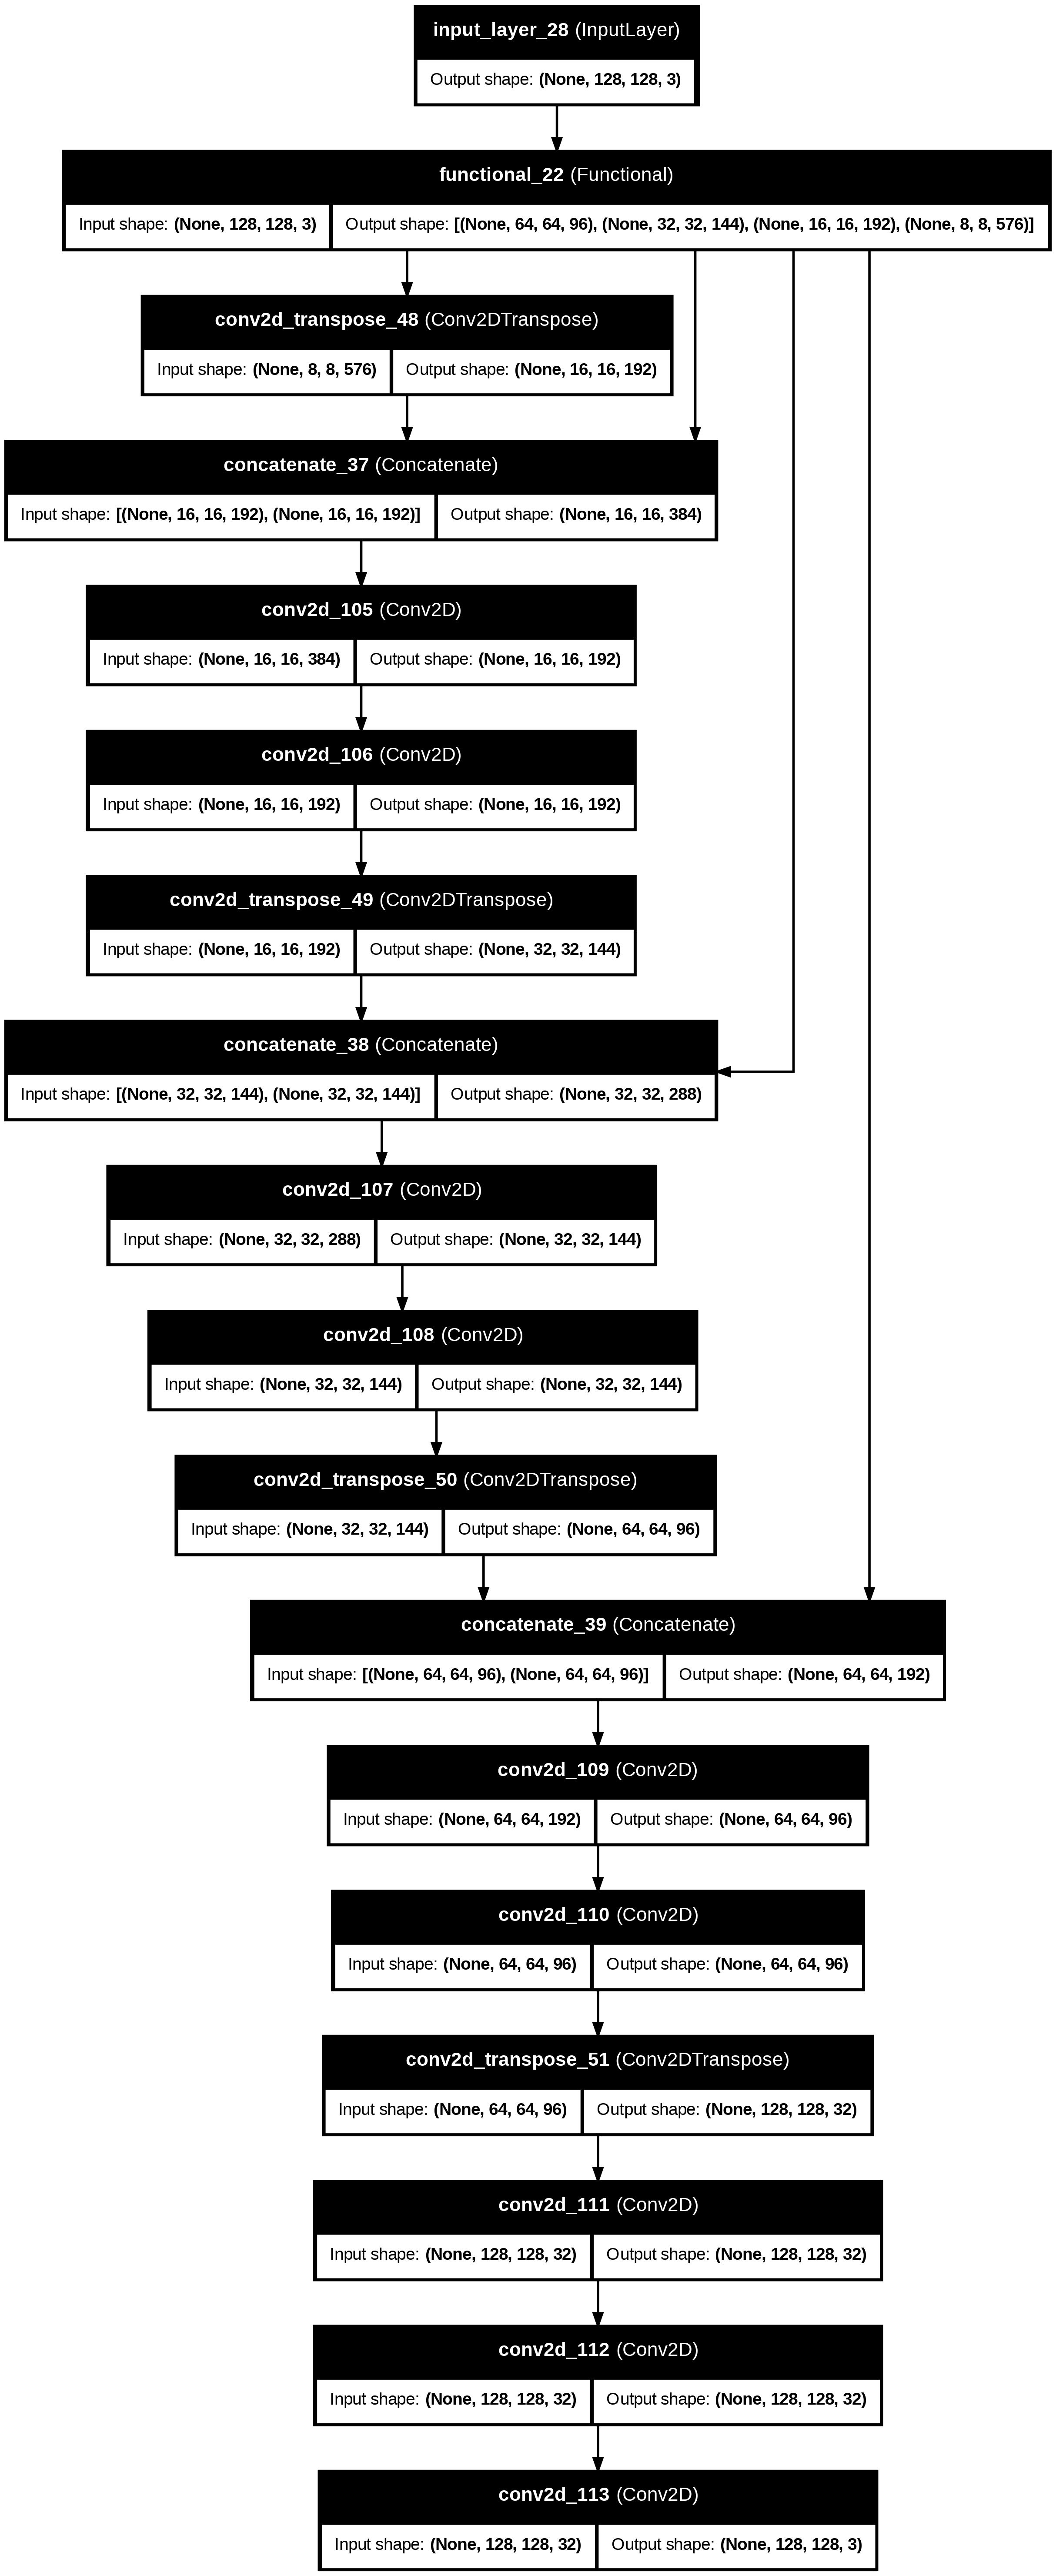

In [91]:

model = unet_mobilenet(input_size=(IMG_HEIGHT, IMG_WIDTH, 3), num_classes=NUM_CLASSES)
model.summary()
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='unet_mobilenet.png', show_shapes=True, show_layer_names=True)
from IPython.display import Image
Image('unet_mobilenet.png')


In [92]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [94]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1
)

history = model.fit(
    data_gen(X_train, Y_train, BATCH_SIZE),
    validation_data=data_gen(X_val, Y_val, BATCH_SIZE),
    steps_per_epoch=len(X_train)//BATCH_SIZE,
    validation_steps=len(X_val)//BATCH_SIZE,
    epochs=EPOCHS
)


Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 0.7510 - loss: 0.5337 - val_accuracy: 0.7157 - val_loss: 0.5888
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.7435 - loss: 0.5204 - val_accuracy: 0.7154 - val_loss: 0.5959
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 169ms/step - accuracy: 0.7495 - loss: 0.4997 - val_accuracy: 0.7331 - val_loss: 0.5857
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 0.7536 - loss: 0.4798 - val_accuracy: 0.7254 - val_loss: 0.6453
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 157ms/step - accuracy: 0.7848 - loss: 0.4477 - val_accuracy: 0.7551 - val_loss: 0.6421
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - accuracy: 0.7891 - loss: 0.4478 - val_accuracy: 0.7432 - val_loss: 0.6803
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - accuracy: 0.7930 - loss: 0.4527 - val_accuracy: 0.7662 - val_loss: 0.5800
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.8414 - loss: 0.4125 - val_accuracy: 0.82

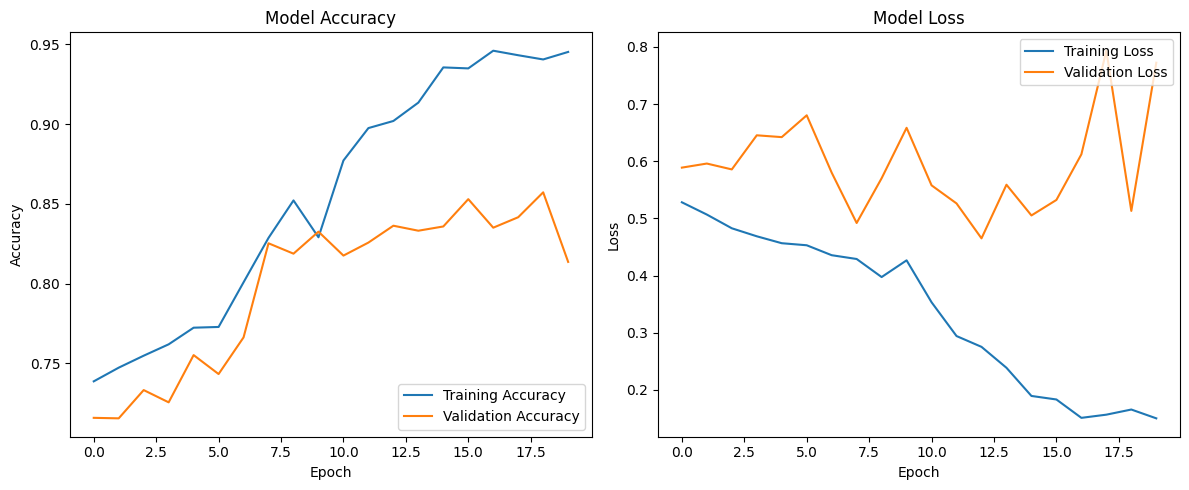

In [95]:
import matplotlib.pyplot as plt


has_validation_data = 'val_loss' in history.history


plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
if has_validation_data:
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
if has_validation_data:
    plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

### Model Saving and Prediction

In [99]:
model.save('cat_dog_segmentation_unet.keras')

In [100]:
loaded_model = tf.keras.models.load_model('cat_dog_segmentation_unet.keras')

In [101]:
import tensorflow as tf
import matplotlib.pyplot as plt

In [102]:
def model_predict(image_path, model):
    # This must be IDENTICAL to your training preprocessing
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
    img_normalized = tf.cast(img, tf.float32) / 255.0


    img_batch = tf.expand_dims(img_normalized, axis=0)

    # Predict
    predicted_masks = model.predict(img_batch)
    return predicted_masks , img


In [105]:
def predict_and_visualize(image_path, model):


    predicted_masks,img = model_predict(image_path, model)

    # The output is (1, H, W, num_classes).
    #  We take the argmax along the
    # class axis to get the final mask (1, H, W).
    pred_mask = tf.argmax(predicted_masks, axis=-1)

    # Remove the batch dimension to get a displayable image (H, W)
    pred_mask = pred_mask[0]
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.title("Input Image")
    # Display the original, un-normalized image
    plt.imshow(tf.keras.utils.array_to_img(img))
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Predicted Mask")
    plt.imshow(pred_mask)
    plt.axis('off')

    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


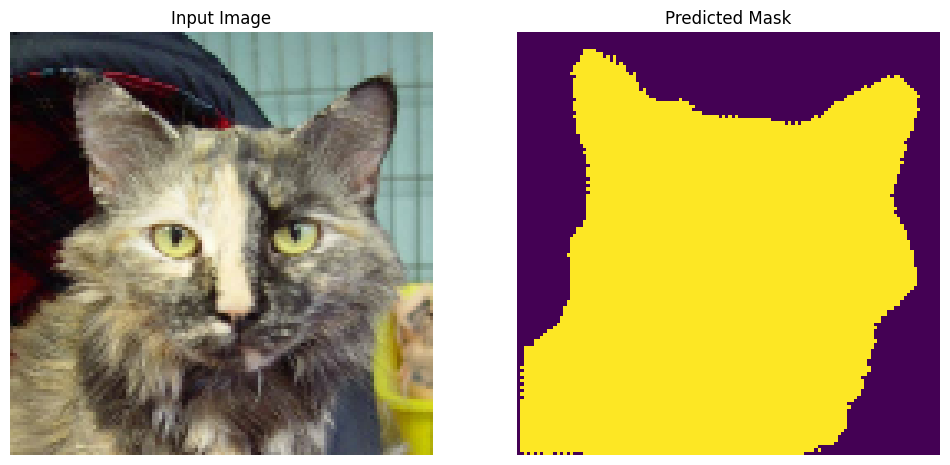

In [106]:
test_path = "/content/drive/MyDrive/Colab Notebooks/data_dataset_voc/JPEGImages/cat.10.jpg"
#test_path = "dataset/car-segmentation/images/003.png"

predict_and_visualize(test_path, loaded_model)